# Improving Performance of Model

Would like to get the loss of the model below 4 on the test data.

In [1]:
%load_ext lab_black

In [42]:
import os
import random
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Method 1- Increasing the size of the test data

The initial dataset provided by Kaggle contains ~10200 images. This means there are roughly only 85 images. Taking 20% for validation => there are generally 70 images per breed to train the model on. Some of these images contain multiple dogs, people and other objects. The initial method will be to reduce the size of the data that is used as validation down to 5% and measure the impact on performance. 

In [27]:
PATH_TO_TRAINING_DATA = "dog_breed_images/dog_breeds/training/"
PATH_TO_VALIDATION_DATA = "dog_breed_images/dog_breeds/validation/"

In [13]:
dog_breed_list = os.listdir(PATH_TO_VALIDATION_DATA)

In [16]:
for dog_breed in dog_breed_list:
    print(
        f"Dog breed '{dog_breed}' has {len(os.listdir(f'{PATH_TO_VALIDATION_DATA}{dog_breed}'))} images."
    )

Dog breed 'australian_terrier' has 20 images.
Dog breed 'toy_poodle' has 16 images.
Dog breed 'great_pyrenees' has 22 images.
Dog breed 'maltese_dog' has 23 images.
Dog breed 'norwich_terrier' has 16 images.
Dog breed 'whippet' has 19 images.
Dog breed 'boston_bull' has 17 images.
Dog breed 'irish_setter' has 18 images.
Dog breed 'rottweiler' has 15 images.
Dog breed 'kelpie' has 17 images.
Dog breed 'schipperke' has 17 images.
Dog breed 'leonberg' has 21 images.
Dog breed 'welsh_springer_spaniel' has 16 images.
Dog breed 'pomeranian' has 22 images.
Dog breed 'pekinese' has 15 images.
Dog breed 'irish_wolfhound' has 20 images.
Dog breed 'blenheim_spaniel' has 20 images.
Dog breed 'basenji' has 22 images.
Dog breed 'african_hunting_dog' has 17 images.
Dog breed 'komondor' has 13 images.
Dog breed 'yorkshire_terrier' has 16 images.
Dog breed 'basset' has 16 images.
Dog breed 'japanese_spaniel' has 21 images.
Dog breed 'standard_schnauzer' has 14 images.
Dog breed 'dhole' has 15 images.
D

In [28]:
for dog_breed in dog_breed_list:
    validation_breed_images = os.listdir(f"{PATH_TO_VALIDATION_DATA}{dog_breed}")
    random.shuffle(validation_breed_images)

    num_validation_images_for_breed = len(validation_breed_images)

    # Taking 25% of 20% => leaving 5% images in validation
    split_index = round(num_validation_images_for_breed * 0.25)

    images_to_move_back_to_training = validation_breed_images[split_index:]
    for image_to_move in images_to_move_back_to_training:
        os.rename(
            f"{PATH_TO_VALIDATION_DATA}{dog_breed}/{image_to_move}",
            f"{PATH_TO_TRAINING_DATA}{dog_breed}/{image_to_move}",
        )

In [29]:
for dog_breed in dog_breed_list:
    print(
        f"Dog breed '{dog_breed}' has {len(os.listdir(f'{PATH_TO_VALIDATION_DATA}{dog_breed}'))} images."
    )

Dog breed 'australian_terrier' has 5 images.
Dog breed 'toy_poodle' has 4 images.
Dog breed 'great_pyrenees' has 6 images.
Dog breed 'maltese_dog' has 6 images.
Dog breed 'norwich_terrier' has 4 images.
Dog breed 'whippet' has 5 images.
Dog breed 'boston_bull' has 4 images.
Dog breed 'irish_setter' has 4 images.
Dog breed 'rottweiler' has 4 images.
Dog breed 'kelpie' has 4 images.
Dog breed 'schipperke' has 4 images.
Dog breed 'leonberg' has 5 images.
Dog breed 'welsh_springer_spaniel' has 4 images.
Dog breed 'pomeranian' has 6 images.
Dog breed 'pekinese' has 4 images.
Dog breed 'irish_wolfhound' has 5 images.
Dog breed 'blenheim_spaniel' has 5 images.
Dog breed 'basenji' has 6 images.
Dog breed 'african_hunting_dog' has 4 images.
Dog breed 'komondor' has 3 images.
Dog breed 'yorkshire_terrier' has 4 images.
Dog breed 'basset' has 4 images.
Dog breed 'japanese_spaniel' has 5 images.
Dog breed 'standard_schnauzer' has 4 images.
Dog breed 'dhole' has 4 images.
Dog breed 'miniature_pinsc

Retraining model using transfer learning on inception

In [31]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [32]:
inception_path = "inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"

In [33]:
pre_trained_model = InceptionV3(
    input_shape=(150, 150, 3), include_top=False, weights=None
)

pre_trained_model.load_weights(inception_path)

In [34]:
for layer in pre_trained_model.layers:
    layer.trainable = False

In [35]:
last_layer = pre_trained_model.get_layer("mixed7")
print("last layer output shape: ", last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [36]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(120, activation="softmax")(x)

model = Model(pre_trained_model.input, x)

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [37]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [38]:
train_generator = train_datagen.flow_from_directory(
    PATH_TO_TRAINING_DATA, batch_size=10, class_mode="sparse", target_size=(150, 150)
)

validation_generator = test_datagen.flow_from_directory(
    PATH_TO_VALIDATION_DATA, batch_size=10, class_mode="sparse", target_size=(150, 150)
)

Found 9727 images belonging to 120 classes.
Found 521 images belonging to 120 classes.


In [40]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=972,
    epochs=25,
    verbose=1,
    validation_data=validation_generator,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 972 steps, validate for 53 steps
Epoch 1/25
972/972 [==============================] - 232s 239ms/step - loss: 3.4718 - acc: 0.1552 - val_loss: 4.2797 - val_acc: 0.2380
Epoch 2/25
972/972 [==============================] - 234s 241ms/step - loss: 3.3865 - acc: 0.1724 - val_loss: 4.0770 - val_acc: 0.2495
Epoch 3/25
972/972 [==============================] - 234s 241ms/step - loss: 3.3388 - acc: 0.1734 - val_loss: 4.6032 - val_acc: 0.2630
Epoch 4/25
972/972 [==============================] - 232s 239ms/step - loss: 3.2687 - acc: 0.1916 - val_loss: 3.9172 - val_acc: 0.2649
Epoch 5/25
972/972 [==============================] - 234s 241ms/step - loss: 3.2767 - acc: 0.1839 - val_loss: 4.6003 - val_acc: 0.2303
Epoch 6/25
972/972 [==============================] - 234s 241ms/step - loss: 3.2470 - acc: 0.1908 - val_loss: 4.5996 - val_acc: 0.2572
Epoch 7/25
972/972 [==============================] - 235s 241ms/step - loss: 3.2371 - acc:

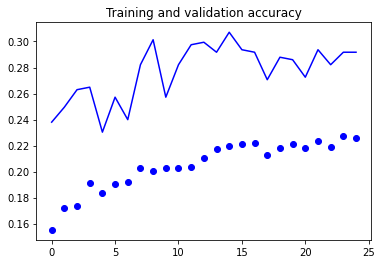

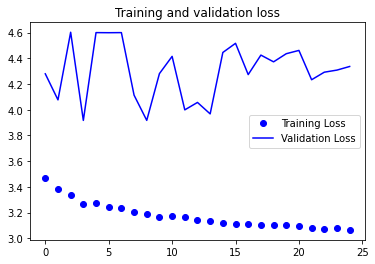

In [43]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")

plt.figure()

plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [44]:
model.save("inception_25_epochs_5_percent_validation.h5")

Displays signs of overfitting. Training for fewer epochs to prevent overfitting

In [47]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dense(120, activation="softmax")(x)

model_15_epochs = Model(pre_trained_model.input, x)

model_15_epochs.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"]
)

In [48]:
history = model_15_epochs.fit_generator(
    train_generator,
    steps_per_epoch=972,
    epochs=15,
    verbose=1,
    validation_data=validation_generator,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 972 steps, validate for 53 steps
Epoch 1/15
972/972 [==============================] - 240s 247ms/step - loss: 4.5945 - acc: 0.0279 - val_loss: 4.5673 - val_acc: 0.0806
Epoch 2/15
972/972 [==============================] - 240s 247ms/step - loss: 4.0102 - acc: 0.0811 - val_loss: 4.4138 - val_acc: 0.1382
Epoch 3/15
972/972 [==============================] - 237s 244ms/step - loss: 3.6923 - acc: 0.1218 - val_loss: 4.4073 - val_acc: 0.2073
Epoch 4/15
972/972 [==============================] - 238s 245ms/step - loss: 3.5285 - acc: 0.1452 - val_loss: 3.9616 - val_acc: 0.2438
Epoch 5/15
972/972 [==============================] - 245s 252ms/step - loss: 3.4403 - acc: 0.1560 - val_loss: 4.1499 - val_acc: 0.2572
Epoch 6/15
972/972 [==============================] - 248s 256ms/step - loss: 3.3867 - acc: 0.1691 - val_loss: 4.1083 - val_acc: 0.2553
Epoch 7/15
972/972 [==============================] - 250s 257ms/step - loss: 3.3475 - acc:

In [51]:
model_15_epochs.save("inception_15_epochs_5_percent_validation.h5")

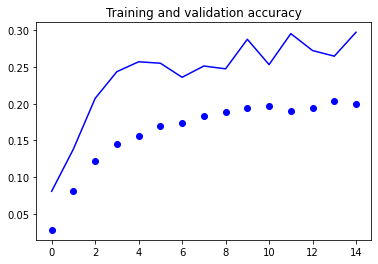

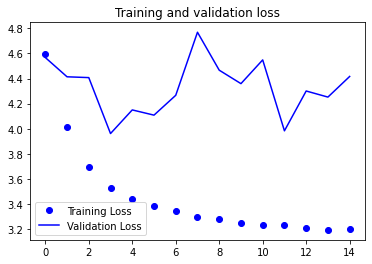

In [50]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")

plt.figure()

plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

Obtains a loss of 4.217 on the test dataset. 